In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# SPDX-License-Identifier: CC-BY-4.0
#
# Code for "Bayesian continual learning and forgetting in neural networks"
# Djohan Bonnet, Kellian Cottart, Tifenn Hirtzlin, Tarcisius Januel, Thomas Dalgaty, Elisa Vianello, Damien Querlioz
# arXiv: 2504.13569
# Portions of the code are adapted from the Pytorch project (BSD-3-Clause)
#
# Author: Kellian Cottart <kellian.cottart@gmail.com>
# Date: 2025-07-03

In [20]:

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import seaborn as sns
import re
AXESSIZE = 28
FONTSIZE = 26
TICKSIZE = 24   
LEGENDSIZE = 26
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
FOLDER = "output-figures"
os.makedirs(FOLDER, exist_ok=True)
# put jax in cpu mode
jax.config.update("jax_platform_name", "cpu")
results_folder = "RESULTS-PMNIST"
# Function to find paths with correct optimizer
def find_paths(results_folder, optimizer):
    paths = []
    for root, dirs, _ in os.walk(results_folder):
        for dir_name in dirs:
            if re.search(f"opt={optimizer}", dir_name):
                paths.append(os.path.join(root, dir_name))
                break
    return paths

# Define the optimizers
optimizers = ["mesu", "foovbdiagonal", "sgd-si", "sgd-online-ewc", "sgd-stream-ewc", "sgd"]

# Find paths for each optimizer
paths = []
for optimizer in optimizers:
    if optimizer == "sgd" and not any(x in results_folder for x in ["ewc", "si"]):
        paths.extend(find_paths(results_folder, optimizer))
    elif optimizer != "sgd":
        paths.extend(find_paths(results_folder, optimizer))
colors = [
    "#a559aa", #MESU
    "#59a89c", #BGD
    "#f0c571", #SI
    "#e02b35", #EWC Online
    "#082a54", #EWC Stream
    '#909090'  #Baseline
]
names = [
    "MESU N=300,000",
    "FOO-VB Diagonal",
    "SI",
    "EWC Online",
    "EWC Stream",
    "SGD Baseline"
]
markers = ["D", "o", "s", "h", "^", "x"]

n_iterations = 5
n_tasks = 200
n_epochs = 1

In [21]:
data = []
for path in paths:
    full_accuracies = []
    full_epistemic_auc = []
    full_aleatoric_auc = []
    full_test_time = []
    full_memory_occupation = []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        weights_path = os.path.join(current_it_path, "weights")
        accuracies = []
        epistemic_auc = []
        aleatoric_auc = []
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
                epistemic_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-epistemic-{suffix}")))
                aleatoric_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-aleatoric-{suffix}")))
        full_memory_occupation.append(jnp.load(os.path.join(current_it_path, "memory_occupation.npy")))
        full_test_time.append(jnp.load(os.path.join(current_it_path, "test_timing.npy")))
        full_accuracies.append(jnp.array(accuracies)) 
        full_epistemic_auc.append(jnp.array(epistemic_auc))
        full_aleatoric_auc.append(jnp.array(aleatoric_auc))
    full_accuracies = jnp.array(full_accuracies)
    full_epistemic_auc = jnp.array(full_epistemic_auc)
    full_aleatoric_auc = jnp.array(full_aleatoric_auc)
    full_test_time = jnp.array(full_test_time)
    full_memory_occupation = jnp.array(full_memory_occupation)
    data.append((full_accuracies, full_epistemic_auc, full_aleatoric_auc, full_test_time, full_memory_occupation))

In [28]:
# Third graph: Mean accuracy on last five tasks
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[3]
    full_time_mean = jnp.mean(full_acc)
    full_time_std = jnp.std(full_acc, axis=1).mean() # STD computed across the 200 tasks
    print(f"{name}: {full_time_mean:.2f} seconds, std: {full_time_std:.2f} seconds")


MESU
N=300,000: 0.07 seconds, std: 0.02 seconds
FOO-VB
Diagonal: 0.10 seconds, std: 0.02 seconds
SI: 0.04 seconds, std: 0.01 seconds
EWC
Online: 0.04 seconds, std: 0.01 seconds
EWC
Stream: 0.04 seconds, std: 0.01 seconds
SGD
Baseline: 0.04 seconds, std: 0.01 seconds


In [29]:
# Third graph: Mean accuracy on last five tasks
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[4]
    full_occupation = jnp.mean(full_acc, axis=0) / 1024**2  # Convert to MB
    print(f"{name} memory occupation: {full_occupation:.2f} MB")

MESU
N=300,000 memory occupation: 0.30 MB
FOO-VB
Diagonal memory occupation: 0.30 MB
SI memory occupation: 0.45 MB
EWC
Online memory occupation: 0.45 MB
EWC
Stream memory occupation: 0.45 MB
SGD
Baseline memory occupation: 0.15 MB


In [30]:
# Third graph: Mean accuracy on last five tasks
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)[-1][-1]
    full_acc_std = jnp.std(full_acc, axis=0)[-1][-1]
    print(f"{name} mean accuracy on last task: {full_acc_mean:.2f}% $\pm$ {full_acc_std:.2f}%")


MESU
N=300,000 mean accuracy on last task: 94.68% $\pm$ 0.14%
FOO-VB
Diagonal mean accuracy on last task: 68.80% $\pm$ 1.94%
SI mean accuracy on last task: 91.09% $\pm$ 0.61%
EWC
Online mean accuracy on last task: 92.75% $\pm$ 0.29%
EWC
Stream mean accuracy on last task: 93.30% $\pm$ 0.43%
SGD
Baseline mean accuracy on last task: 93.10% $\pm$ 0.22%


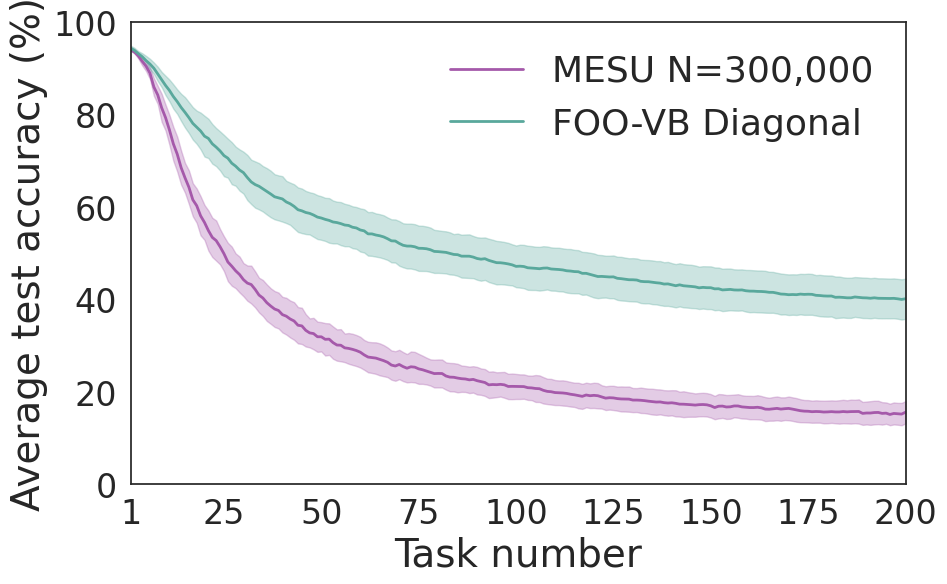

In [31]:
SIZE = (10, 6)
full_acc_mesu = data[0][0]*100
full_acc_foo_vb = data[1][0]*100
mean_acc_mesu = jnp.mean(full_acc_mesu, axis=0)
mean_acc_foo_vb = jnp.mean(full_acc_foo_vb, axis=0)
mean_acc_mesu_std = jnp.std(full_acc_mesu, axis=0)
mean_acc_foo_vb_std = jnp.std(full_acc_foo_vb, axis=0)
window = 1
x = jnp.arange(window, n_tasks + 1)
y_mesu = jnp.array([mean_acc_mesu[t][:t].mean() for t in x])
y_foo_vb = jnp.array([mean_acc_foo_vb[t][:t].mean() for t in x])
y_mesu_std = jnp.array([mean_acc_mesu_std[t][:t].mean() for t in x])
y_foo_vb_std = jnp.array([mean_acc_foo_vb_std[t][:t].mean() for t in x])

fig, ax = plt.subplots(figsize=SIZE)
ax.plot(x, y_mesu, color=colors[0], label="MESU N=300,000", linewidth=2)
ax.plot(x, y_foo_vb, color=colors[1], label="FOO-VB Diagonal", linewidth=2)
ax.fill_between(x, y_mesu - y_mesu_std, y_mesu + y_mesu_std, color=colors[0], alpha=0.3)
ax.fill_between(x, y_foo_vb - y_foo_vb_std, y_foo_vb + y_foo_vb_std, color=colors[1], alpha=0.3)
ax.legend(loc="upper right", fontsize=LEGENDSIZE, frameon=False)
ax.set_xlabel("Task number", fontsize=AXESSIZE)
ax.set_ylabel("Average test accuracy (%)", fontsize=AXESSIZE)
ax.tick_params(axis='both', which='both', labelsize=TICKSIZE)
sns.despine(top=False, right=False)
ax.set_ylim(0, 100)
ax.set_xlim(window, n_tasks)
ax.set_xticks([window] +  list(range(0, n_tasks + 1, 25)[1:]))

# save the figure
fig.savefig(os.path.join(FOLDER, "pmnist-mean-accuracy-200-tasks.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "pmnist-mean-accuracy-200-tasks.svg"), bbox_inches="tight")
plt.show()
    

In [32]:
y_mesu

Array([94.058495, 93.56972 , 92.721695, 91.55499 , 90.49079 , 88.98204 ,
       85.99361 , 84.25856 , 81.48326 , 79.35377 , 76.6898  , 73.68306 ,
       71.45711 , 68.53008 , 66.32118 , 64.29037 , 61.582535, 60.293694,
       58.10602 , 56.67068 , 54.909187, 53.434135, 52.742737, 51.41427 ,
       49.898235, 48.109055, 47.20234 , 46.201214, 45.399944, 44.283127,
       43.54121 , 43.224724, 42.183617, 40.944218, 40.307926, 39.30322 ,
       38.574368, 37.930954, 37.609768, 36.714195, 36.382744, 35.770424,
       35.339382, 34.41297 , 34.279873, 33.31291 , 32.76353 , 32.6131  ,
       31.92688 , 31.913422, 31.368584, 31.411953, 30.654709, 30.134699,
       30.091272, 29.523312, 29.404137, 29.200724, 28.938303, 28.58971 ,
       27.998142, 27.530499, 27.414661, 27.304972, 27.030573, 26.753899,
       26.399015, 25.798307, 25.593416, 25.924593, 25.46195 , 25.113737,
       25.429125, 25.341982, 24.975267, 24.778751, 24.497509, 24.1961  ,
       23.955978, 23.983725, 23.96756 , 23.431906, 

In [33]:
y_foo_vb

Array([94.41506 , 93.92428 , 93.21448 , 92.55258 , 91.69071 , 90.95921 ,
       90.044945, 88.814606, 87.60551 , 86.323524, 85.236565, 83.92128 ,
       82.81635 , 81.56766 , 80.49333 , 79.35034 , 78.11086 , 77.27753 ,
       76.46815 , 75.34496 , 74.8551  , 73.685455, 72.9678  , 72.14352 ,
       71.14207 , 70.576   , 69.49401 , 68.84651 , 68.01793 , 67.452126,
       66.38712 , 65.44058 , 64.86949 , 64.498726, 63.94603 , 63.407234,
       62.8255  , 62.221874, 61.982662, 61.759518, 61.1025  , 60.714863,
       60.151447, 59.42226 , 59.179264, 58.823254, 58.63382 , 58.27612 ,
       57.82644 , 57.623203, 57.332874, 57.108303, 56.769287, 56.64163 ,
       56.414192, 56.112003, 56.01331 , 55.631912, 55.475677, 55.03686 ,
       54.84467 , 54.193775, 54.187496, 53.9461  , 53.78575 , 53.539574,
       53.14727 , 52.6878  , 52.646408, 52.13433 , 51.72307 , 51.55666 ,
       51.54848 , 51.40046 , 51.078156, 51.056164, 50.97465 , 50.761375,
       50.39859 , 50.353092, 50.26813 , 50.189743, 

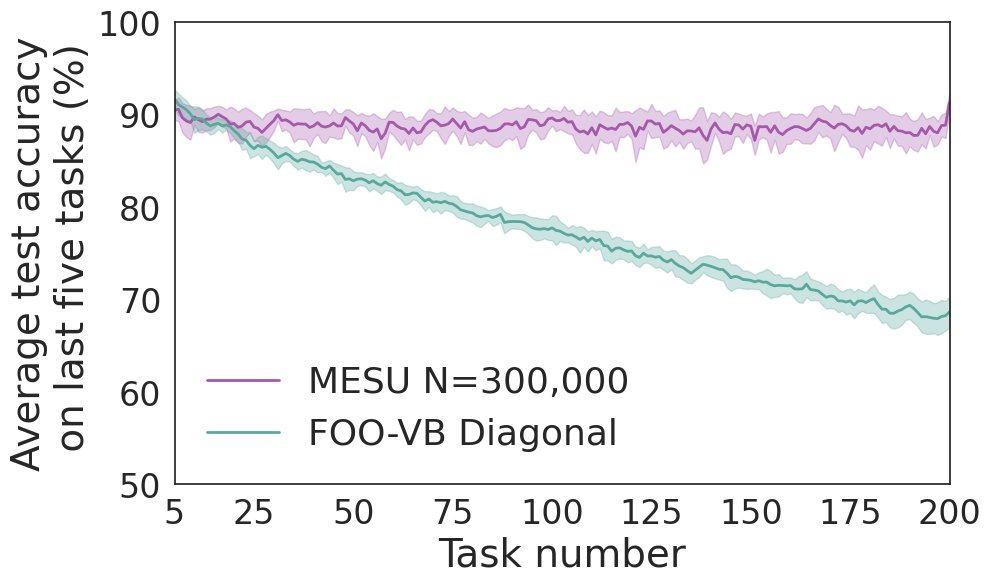

In [34]:
full_acc_mesu = data[0][0]*100
full_acc_foo_vb = data[1][0]*100
mean_acc_mesu = jnp.mean(full_acc_mesu, axis=0)
mean_acc_foo_vb = jnp.mean(full_acc_foo_vb, axis=0)
mean_acc_mesu_std = jnp.std(full_acc_mesu, axis=0)
mean_acc_foo_vb_std = jnp.std(full_acc_foo_vb, axis=0)
window = 5
x = jnp.arange(window, n_tasks + 1)
y_mesu = jnp.array([mean_acc_mesu[t][t-window:t].mean() for t in x])
y_foo_vb = jnp.array([mean_acc_foo_vb[t][t-window:t].mean() for t in x])
y_mesu_std = jnp.array([mean_acc_mesu_std[t][t-window:t].mean() for t in x])
y_foo_vb_std = jnp.array([mean_acc_foo_vb_std[t][t-window:t].mean() for t in x])

fig, ax = plt.subplots(figsize=SIZE)
ax.plot(x, y_mesu, color=colors[0], label="MESU N=300,000", linewidth=2)
ax.plot(x, y_foo_vb, color=colors[1], label="FOO-VB Diagonal", linewidth=2)
ax.fill_between(x, y_mesu - y_mesu_std, y_mesu + y_mesu_std, color=colors[0], alpha=0.3)
ax.fill_between(x, y_foo_vb - y_foo_vb_std, y_foo_vb + y_foo_vb_std, color=colors[1], alpha=0.3)
ax.legend(loc="lower left", fontsize=LEGENDSIZE, frameon=False)
ax.set_xlabel("Task number", fontsize=AXESSIZE)
ax.set_ylabel("Average test accuracy\n on last five tasks (%)", fontsize=AXESSIZE)
ax.tick_params(axis='both', which='both', labelsize=TICKSIZE)
sns.despine(top=False, right=False)
ax.set_ylim(50, 100)
ax.set_xlim(window, n_tasks)
ax.set_xticks([window] +  list(range(0, n_tasks + 1, 25)[1:]))
# save the figure
fig.savefig(os.path.join(FOLDER, "pmnist-mean-accuracy-last-five-tasks-200.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "pmnist-mean-accuracy-last-five-tasks-200.svg"), bbox_inches="tight")
plt.show()
    

In [35]:
y_mesu.mean()

Array(88.75478, dtype=float32)

In [36]:
y_foo_vb.mean()

Array(77.69423, dtype=float32)

In [37]:
y_mesu

Array([90.49079 , 90.58413 , 89.65105 , 89.308495, 89.14623 , 89.75641 ,
       89.469154, 89.2476  , 89.504814, 89.513626, 89.73718 , 90.04127 ,
       89.77325 , 89.53566 , 88.97797 , 89.04087 , 88.633415, 88.767235,
       89.19432 , 89.27205 , 88.65546 , 88.52124 , 88.07372 , 88.514824,
       88.95513 , 89.36138 , 89.99359 , 89.359375, 89.44271 , 89.20553 ,
       88.846954, 89.027245, 88.979576, 88.97756 , 88.61339 , 88.78526 ,
       89.137825, 88.75    , 88.65826 , 88.78406 , 89.09736 , 88.77484 ,
       88.79247 , 89.69192 , 89.31772 , 88.993195, 88.258415, 89.092155,
       88.80729 , 88.30569 , 88.107376, 88.45434 , 87.40505 , 87.981575,
       89.188705, 89.159454, 88.76403 , 88.522446, 88.44031 , 87.96515 ,
       88.556885, 88.03566 , 88.12701 , 88.833336, 89.276054, 89.45553 ,
       89.18471 , 88.79968 , 88.85778 , 89.039665, 89.52805 , 89.04728 ,
       88.54888 , 89.239586, 88.3702  , 88.19031 , 88.44071 , 88.548485,
       88.66547 , 88.25601 , 88.2488  , 88.30009 , 

In [38]:
y_foo_vb

Array([91.69071 , 91.09335 , 90.81891 , 90.54287 , 90.083336, 89.45994 ,
       89.60337 , 89.517235, 89.09817 , 88.77604 , 88.93831 , 89.0597  ,
       88.78125 , 88.88903 , 88.70273 , 88.27605 , 87.90344 , 87.3706  ,
       87.23839 , 86.6859  , 86.31931 , 86.6819  , 86.467155, 86.56931 ,
       86.24519 , 85.85337 , 85.337746, 85.567314, 85.8089  , 85.57493 ,
       85.177895, 84.942314, 85.17829 , 85.07572 , 84.892235, 84.870995,
       84.64064 , 84.296875, 84.15546 , 84.44912 , 83.98999 , 83.57172 ,
       83.617   , 82.98879 , 83.06451 , 82.84496 , 83.02284 , 83.0649  ,
       82.91146 , 82.6274  , 82.85337 , 82.532455, 82.356575, 82.72036 ,
       82.44351 , 82.25922 , 81.879005, 81.762825, 81.33093 , 81.360985,
       81.52925 , 81.48197 , 81.05609 , 80.65144 , 80.86419 , 80.52044 ,
       80.58174 , 80.47156 , 80.61779 , 80.41587 , 80.33734 , 80.064514,
       79.702324, 79.57172 , 79.44832 , 79.36739 , 79.06652 , 78.93831 ,
       79.04448 , 79.08614 , 78.865395, 78.99079 , 